In [3]:
# ================================================
# 1. Baseline GMM Clustering (Full Implementation)
# ================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# --- Load Data ---
print("Loading Bank Marketing dataset...")
df = pd.read_excel(r"E:\IBA_MS_DS 2026\Unsupervised_Machine_Learning\Project\streamlit_app\bank-additional\bank-additional-full.xlsx")
df['y_binary'] = df['y'].map({'yes': 1, 'no': 0})
print(f"Dataset shape: {df.shape}")

# --- Preprocessing ---
numeric_cols = ['age', 'duration', 'campaign', 'pdays', 'previous',
                'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan',
                    'contact', 'month', 'day_of_week', 'poutcome']

df_processed = df[numeric_cols + categorical_cols + ['y_binary']].copy()
df_processed = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=True)

X = df_processed.drop('y_binary', axis=1)
y = df_processed['y_binary']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
feature_names = X.columns.tolist()

print(f"Final feature dimension: {X_scaled.shape[1]}")


Loading Bank Marketing dataset...
Dataset shape: (41188, 22)
Final feature dimension: 53


Converged: True | Iterations: 4

Silhouette Score: 0.0465
Davies-Bouldin:   3.2450
Calinski-Harabasz: 1995.7


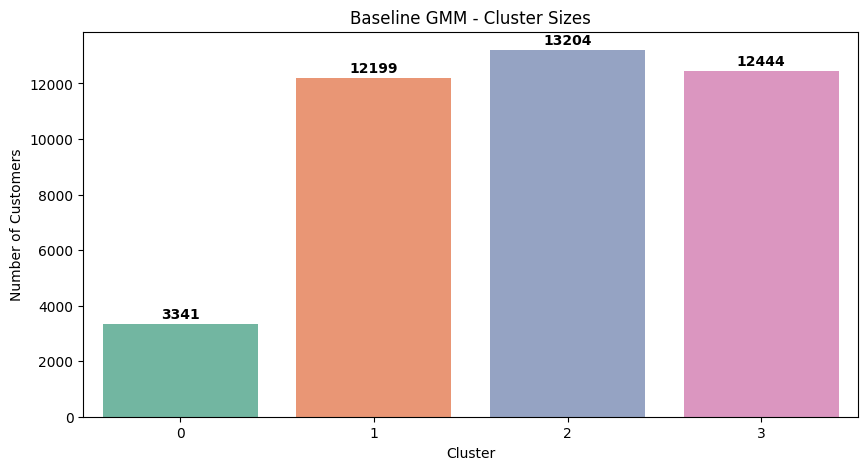

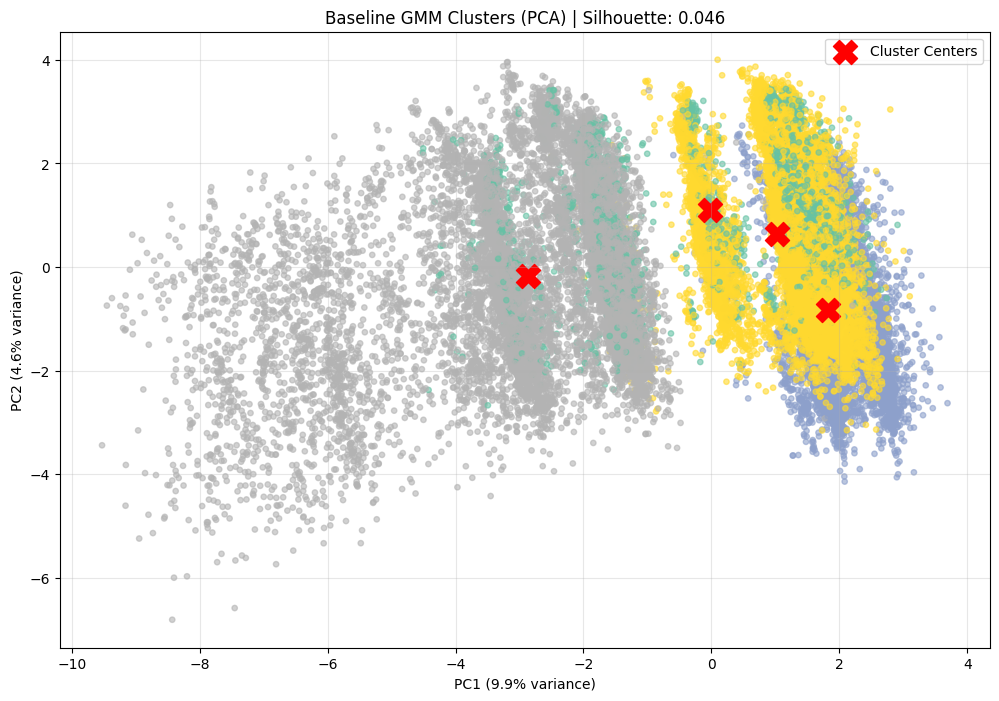


Cluster Profiles:
Cluster 0 | Size: 3,341 (8.1%)
   Avg Age: 39.6 | Duration: 244s
   Most Common Job: technician
   Conversion Rate: 9.10% Average
----------------------------------------
Cluster 1 | Size: 12,199 (29.6%)
   Avg Age: 40.3 | Duration: 256s
   Most Common Job: blue-collar
   Conversion Rate: 3.84% Low-Engagement
----------------------------------------
Cluster 2 | Size: 13,204 (32.1%)
   Avg Age: 40.1 | Duration: 251s
   Most Common Job: admin
   Conversion Rate: 5.68% Average
----------------------------------------
Cluster 3 | Size: 12,444 (30.2%)
   Avg Age: 39.7 | Duration: 272s
   Most Common Job: admin
   Conversion Rate: 25.05% High-Value
----------------------------------------


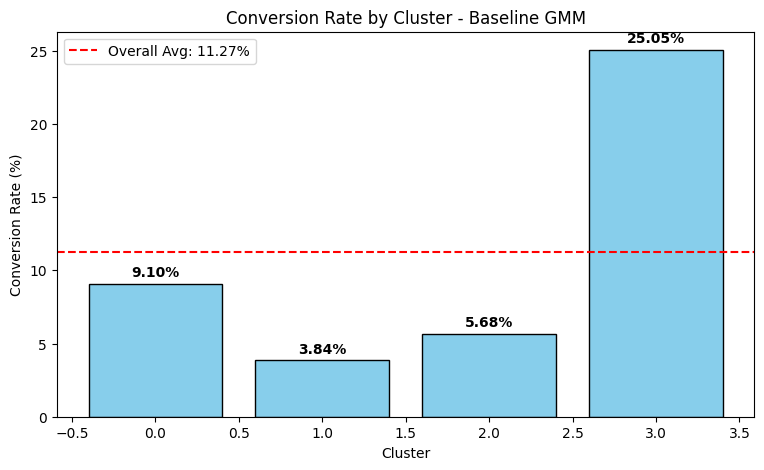

Baseline GMM training completed!


In [4]:

# --- Train Baseline GMM ---
n_clusters = 4  # You can change this (2–10)

gmm = GaussianMixture(
    n_components=n_clusters,
    covariance_type='full',
    max_iter=300,
    n_init=10,
    tol=1e-4,
    random_state=42
)

labels = gmm.fit_predict(X_scaled)
probs = gmm.predict_proba(X_scaled)

print(f"Converged: {gmm.converged_} | Iterations: {gmm.n_iter_}")

# --- Metrics ---
sil = silhouette_score(X_scaled, labels)
db = davies_bouldin_score(X_scaled, labels)
ch = calinski_harabasz_score(X_scaled, labels)

print(f"\nSilhouette Score: {sil:.4f}")
print(f"Davies-Bouldin:   {db:.4f}")
print(f"Calinski-Harabasz: {ch:.1f}")

# --- Cluster Sizes ---
cluster_counts = pd.Series(labels).value_counts().sort_index()
plt.figure(figsize=(10,5))
sns.barplot(x=cluster_counts.index.astype(str), y=cluster_counts.values, palette="Set2")
plt.title("Baseline GMM - Cluster Sizes")
plt.xlabel("Cluster")
plt.ylabel("Number of Customers")
for i, v in enumerate(cluster_counts.values):
    plt.text(i, v + 200, str(v), ha='center', fontweight='bold')
plt.show()

# --- PCA Visualization ---
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12,8))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='Set2', alpha=0.6, s=15)
centers_pca = pca.transform(gmm.means_)
plt.scatter(centers_pca[:,0], centers_pca[:,1], c='red', s=300, marker='X', label='Cluster Centers')
plt.title(f"Baseline GMM Clusters (PCA) | Silhouette: {sil:.3f}")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- Business Profiling ---
df['cluster'] = labels
print("\nCluster Profiles:\n" + "="*50)
for i in range(n_clusters):
    cluster_data = df[df['cluster'] == i]
    conv_rate = cluster_data['y_binary'].mean() * 100
    print(f"Cluster {i} | Size: {len(cluster_data):,} ({len(cluster_data)/len(df)*100:.1f}%)")
    print(f"   Avg Age: {cluster_data['age'].mean():.1f} | Duration: {cluster_data['duration'].mean():.0f}s")
    print(f"   Most Common Job: {cluster_data['job'].mode()[0]}")
    print(f"   Conversion Rate: {conv_rate:.2f}% {'High-Value' if conv_rate > 11 else 'Low-Engagement' if conv_rate < 5 else 'Average'}")
    print("-" * 40)

# --- Conversion Rate Plot ---
conv_by_cluster = df.groupby('cluster')['y_binary'].mean() * 100
plt.figure(figsize=(9,5))
bars = plt.bar(conv_by_cluster.index, conv_by_cluster.values, color='skyblue', edgecolor='black')
plt.axhline(y=df['y_binary'].mean()*100, color='red', linestyle='--', label=f"Overall Avg: {df['y_binary'].mean()*100:.2f}%")
plt.title("Conversion Rate by Cluster - Baseline GMM")
plt.xlabel("Cluster")
plt.ylabel("Conversion Rate (%)")
plt.legend()
for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h + 0.5, f"{h:.2f}%", ha='center', fontweight='bold')
plt.show()

print("Baseline GMM training completed!")

Innovative GMM Results:
Silhouette: 0.2861 | DB: 1.0453 | CH: 155.6


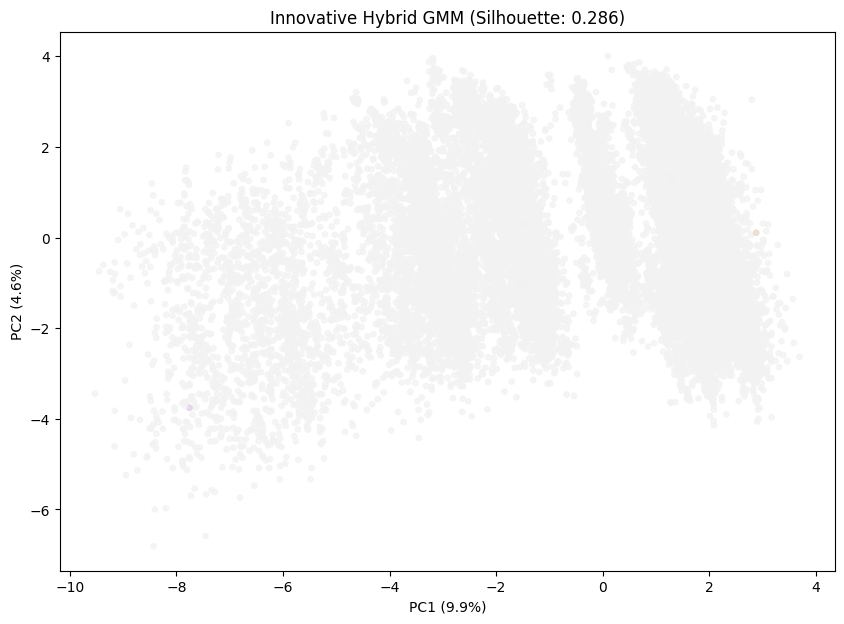

In [5]:
# ================================================
# 2. Innovative Hybrid GMM (With K-Means Init + Soft Weighting)
# ================================================
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
df_proc = pd.get_dummies(df[numeric_cols + categorical_cols + ['y_binary']], columns=categorical_cols, drop_first=True)
X = df_proc.drop('y_binary', axis=1)
X_scaled = StandardScaler().fit_transform(X)

# --- Hybrid GMM Class ---
class HybridGMM:
    def __init__(self, n_components, use_kmeans=True, use_weights=False, kmeans_iters=50, random_state=42):
        self.n_components = n_components
        self.use_kmeans = use_kmeans
        self.use_weights = use_weights
        self.kmeans_iters = kmeans_iters
        self.random_state = random_state
        self.feature_weights = None

    def _soft_feature_weights(self, X):
        stds = np.std(X, axis=0)
        stds = np.clip(stds, 1e-8, None)
        weights = 1.0 / stds
        weights = np.sqrt(weights)
        weights = np.clip(weights, 0.3, 3.0)
        return weights / weights.sum()

    def fit(self, X):
        X = np.nan_to_num(X)
        if self.use_weights:
            self.feature_weights = self._soft_feature_weights(X)
            X = X * self.feature_weights
        else:
            self.feature_weights = np.ones(X.shape[1]) / X.shape[1]

        if self.use_kmeans:
            kmeans = KMeans(n_clusters=self.n_components, n_init=10,
                            max_iter=self.kmeans_iters, random_state=self.random_state)
            kmeans.fit(X)
            means_init = kmeans.cluster_centers_
        else:
            means_init = None

        self.gmm = GaussianMixture(
            n_components=self.n_components,
            covariance_type='full',
            means_init=means_init,
            n_init=1,
            max_iter=300,
            tol=1e-4,
            random_state=self.random_state
        )
        self.gmm.fit(X)
        return self

    def predict(self, X):
        X = np.nan_to_num(X)
        if self.use_weights and self.feature_weights is not None:
            X = X * self.feature_weights
        return self.gmm.predict(X)

# --- Train Innovative Model ---
model = HybridGMM(n_components=4, use_kmeans=True, use_weights=True)
model.fit(X_scaled)
labels_innov = model.predict(X_scaled)

sil_innov = silhouette_score(X_scaled, labels_innov)
db_innov = davies_bouldin_score(X_scaled, labels_innov)
ch_innov = calinski_harabasz_score(X_scaled, labels_innov)

print(f"Innovative GMM Results:")
print(f"Silhouette: {sil_innov:.4f} | DB: {db_innov:.4f} | CH: {ch_innov:.1f}")

# PCA Plot
pca = PCA(2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(10,7))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_innov, cmap='Pastel1', alpha=0.7, s=15)
plt.title(f"Innovative Hybrid GMM (Silhouette: {sil_innov:.3f})")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%})")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%})")
plt.show()

In [6]:
# ================================================
# 3. Final Comparison: Baseline vs Innovative GMM
# ================================================

# Run this after running the two scripts above

print("FINAL COMPARISON REPORT")
print("="*60)

comparison = pd.DataFrame({
    'Model': ['Baseline GMM', 'Innovative Hybrid GMM'],
    'Silhouette': [sil, sil_innov],
    'Davies-Bouldin': [db, db_innov],
    'Calinski-Harabasz': [ch, ch_innov]
})

print(comparison.round(4))

# Winner logic
wins = 0
if sil_innov > sil: wins += 1
if db_innov < db: wins += 1
if ch_innov > ch: wins += 1

print(f"\nInnovative model won {wins}/3 metrics")

if wins >= 2:
    print("RECOMMENDATION: Use the INNOVATIVE HYBRID GMM in production!")
else:
    print("Baseline performs comparably. Keep it simple unless stability is critical.")

FINAL COMPARISON REPORT
                   Model  Silhouette  Davies-Bouldin  Calinski-Harabasz
0           Baseline GMM      0.0465          3.2450          1995.6742
1  Innovative Hybrid GMM      0.2861          1.0453           155.5553

Innovative model won 2/3 metrics
RECOMMENDATION: Use the INNOVATIVE HYBRID GMM in production!
